# Fitting Saturation-based Simulation Data With an Additional Forward Loss
Can having an additional loss from a forward model improve overfitting? 

The forward model is trained on the same data(Which now seems a bit questionable to me). It takes the predicted TMPs(In this case, scaled using the standard scaler, so don't need to worry about that part) and uses that to generate curve fitting parameters for both wavelength. The idea is to have this forward model **frozen** and then predict the probable curve fitting parameters using the prediction of the reverse model. Then take the difference between this and the original curve fitting parameters fed to the reverse model and calculate a loss term. This loss term is then added on to the original loss term.

# Things To do
## Using Curve Fitting Parameters directly to predict TMPs
Even with a 5 layers deep network, the 8 fitting parameter inputs were not sufficient to predict Fetal Saturation. Both the train and test error were near 1.0 (essentially predicting the mean). What does this actually mean? Perhaps the fitting parameters contain more information about the mother rather than the fetus. 

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU, PerceptronBN, PerceptronDO, PerceptronBD
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity, create_curve_fitting_param
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
# data = interpolate_exp(data, weights=[1, 0.7])
# data['Intensity'] = data['Interpolated Intensity']
# data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
# data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log


# data = create_ratio_and_intensity(data, True)
# data = create_ratio(data, True)
data = create_spatial_intensity(data)
# data = create_curve_fitting_param(data, (1.0, 0.8))

data.head() 
# NOTE: Have only 1 on at the same time!

# Cleanup
data.dropna(inplace=True)

# Load Forward Model

In [13]:
# # Load Model Code
import joblib
from inverse_modelling_tfo.data.intensity_interpolation import generate_fit_eqn_x

model_name = 'forward_curve_fit_paramv2'
fwd_model = PerceptronBD([5, 4, 8, 16, 40], dropout_rates = [0.01, 0.1, 0.1, 0.1])
fwd_model.load_state_dict(torch.load(rf'../models/{model_name}'))
fwd_model.eval()
# The input TMPs will already be scaled. No need to further use an x_scaler
y_scaler_fwd = joblib.load(rf'../models/{model_name}_yscaler')
x_scaler_fwd = joblib.load(rf'../models/{model_name}_xscaler')

class FwdModel:
    """
    Given a set of TMPs generate the spatial intensities.
    (The input and output scaling is considered to be equal, so no scaling is done. But in a 
    non-ideal world, you would expect a pair of scalers the input and one for output)
    Make sure the input TMPs are given in the same order as [x_columns]
    """
    x_columns = ['Maternal Wall Thickness', 'Maternal Hb Concentration', "Maternal Saturation", 
             "Fetal Hb Concentration", "Fetal Saturation"]
    
    
    def __init__(self, fwd_model: nn.Module) -> None:
        self.fwd_model = fwd_model
        self._prep_model()
        
    def _prep_model(self):
        # Send to CUDA
        self.fwd_model = self.fwd_model.cuda()
        # Set model to Eval mode (Disables Dropout layers)
        self.fwd_model = self.fwd_model.eval()
        # Freeze all layers
        # for param in self.fwd_model.parameters():
        #     param.requires_grad = False
    
    def forward(self, x: torch.Tensor):
        return self.fwd_model(x.cuda())


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [14]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Fetal Saturation']
y_columns = ['Maternal Wall Thickness', 'Maternal Hb Concentration', "Maternal Saturation", 
             "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Hb Concentration']
# y_columns = ['Fetal Saturation']
# y_columns = ['Fetal Hb Concentration']

## X -> Predictors
x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))

## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

# Defining Forward Model Loss

In [15]:
class CombinedLoss(nn.Module):
    """Calculates a combined reconstruction and inverse loss. The reconstruction loss is an MSE of 
    SI by a Forward model using TMPs predicted by the inverse model. The inverse loss is 
    the MSE from the ground truth TMPs. 
    """
    def __init__(self, loaded_forward_model: nn.Module, tmp_count: int,
                inverse_loss_weight: float) -> None:
        super().__init__()
        self.fwd = FwdModel(loaded_forward_model)
        self.tmp_count = tmp_count
        self.mse_loss_recon = nn.MSELoss()
        self.mse_loss_inv = nn.MSELoss()
        self.inverse_loss_weight = inverse_loss_weight

    
    def forward(self, predicted_tmps, targets):
        tmp_taget = targets[:, :self.tmp_count]
        si_target = targets[:, self.tmp_count:]
        predicted_si = self.fwd.forward(predicted_tmps)
        reconstruction_loss = self.mse_loss_inv(predicted_si, si_target)
        inverse_loss = self.mse_loss_inv(predicted_tmps, tmp_taget)
        return (1 - self.inverse_loss_weight) * reconstruction_loss + self.inverse_loss_weight * inverse_loss

## Model Configuration

In [16]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 64, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns + x_columns, # Pass in both the Ground Truth TMP + SI (Custom Loss)
    # Same Validation Method as the Forward Training Model : i.e. the same set is always held out
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data["Maternal Wall Thickness"].unique()[4])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}
loss = CombinedLoss(fwd_model, len(y_columns), 0.5)
# trainer_factory = ModelTrainerFactory(PerceptronReLU, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronBN, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronDO, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 20, 15, 10, 5, OUT_FEATURES], 'dropout_rates': [0.01, 0.01, 0.01, 0.01]}, generate_data_loaders, datagen_kw, 100, loss)

## Hyper Parameter Tuning

In [19]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [20]:
# Hyper Parameter Search 
iteration_config = {
    "lr" : tune.loguniform(1e-4, 1e-2),
    # "batch_size": tune.choice([128, 256]),
    "momentum": tune.uniform(0.9, 0.99),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


2023-10-16 11:19:52,096	INFO worker.py:1621 -- Started a local Ray instance.
2023-10-16 11:19:53,054	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-10-16 11:19:53,068	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2023-10-16 11:19:54 (running for 00:00:01.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 0/64 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_with_tuning_2023-10-16_11-19-53
Number of trials: 70/80 (70 PENDING)
+-------------------------------+----------+-------+-------------+------------+
| Trial name                    | status   | loc   |          lr |   momentum |
|-------------------------------+----------+-------+-------------+------------|
| train_with_tuning_99f17_00000 | PENDING  |       | 0.000561152 |   0.985564 |
| train_with_tuning_99f17_00001 | PENDING  |       | 0.00157513  |   0.914042 |
| train_with_tuning_99f17_00002 | PENDING  |       | 0.000130667 |   0.977956 |
| train_with_tuning_99f17_00003 | PENDING  |       | 0.00260702  |   0.901853 |
| train_with_tuning_99f17_00004 | PENDING  |       |

Trial name,combined_loss,train_loss,val_loss
train_with_tuning_99f17_00000,0.0979792,0.42392,0.231127
train_with_tuning_99f17_00001,0.0939966,0.406541,0.231211
train_with_tuning_99f17_00002,0.200626,0.564815,0.355206
train_with_tuning_99f17_00003,0.0905814,0.391533,0.23135
train_with_tuning_99f17_00004,0.0910248,0.394596,0.230679
train_with_tuning_99f17_00005,0.213508,0.573794,0.372098
train_with_tuning_99f17_00006,0.136945,0.477698,0.286677
train_with_tuning_99f17_00007,0.20981,0.573189,0.366041
train_with_tuning_99f17_00008,0.15079,0.498447,0.30252
train_with_tuning_99f17_00009,0.0955912,0.416049,0.229759


== Status ==
Current time: 2023-10-16 11:19:59 (running for 00:00:06.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 0/64 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_with_tuning_2023-10-16_11-19-53
Number of trials: 72/80 (70 PENDING, 2 RUNNING)
+-------------------------------+----------+-----------------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name                    | status   | loc                   |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|-------------------------------+----------+-----------------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_with_tuning_99f17_00000 | RUNNING  | 169.237.32.34:3076860 | 0.000561152 |   0.985564 |     0.5508

2023-10-16 11:27:56,244	INFO tune.py:1148 -- Total run time: 483.18 seconds (483.12 seconds for the tuning loop).


== Status ==
Current time: 2023-10-16 11:27:56 (running for 00:08:03.13)
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 40.000: -0.09207540969023079 | Iter 20.000: -0.0944871321268913 | Iter 10.000: -0.09950395803206977 | Iter 5.000: -0.14257984504718552
Logical resource usage: 0/64 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_with_tuning_2023-10-16_11-19-53
Number of trials: 80/80 (80 TERMINATED)
+-------------------------------+------------+-----------------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name                    | status     | loc                   |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|-------------------------------+------------+-----------------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_with_tuning_99f17_00000 | TERMINATED

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [73]:
# best_trial.config

## Custom Training

In [21]:
set_seed(42)
trainer = trainer_factory.create()
# trainer.change_batch_size(16)
# trainer.set_optimizer(SGD, {'lr': best_trial.config['lr'], 'momentum': best_trial.config['lr']["momentum"]})
trainer.set_optimizer(SGD, {'lr': 1.25e-3, 'momentum': 0.96})
trainer.epochs = 50
trainer.run()

In [ ]:
# trainer.epochs = 50
# trainer.run()

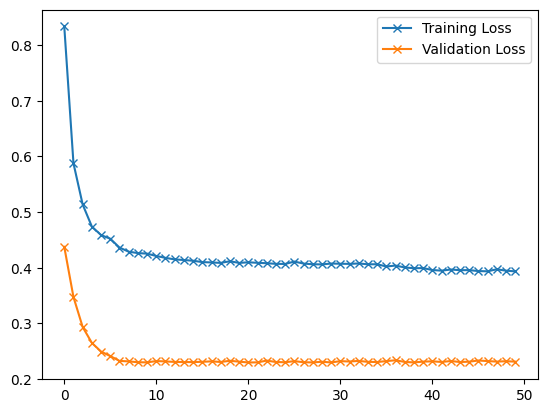

In [22]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [23]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.01, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=15, bias=True)
    (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.01, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=15, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout1d(p=0.01, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=5, bias=True)
    (13): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout1d(p=0.01, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=5, out_features=5, bias=True)
    (17): Flatten(start_dim=1, end_di

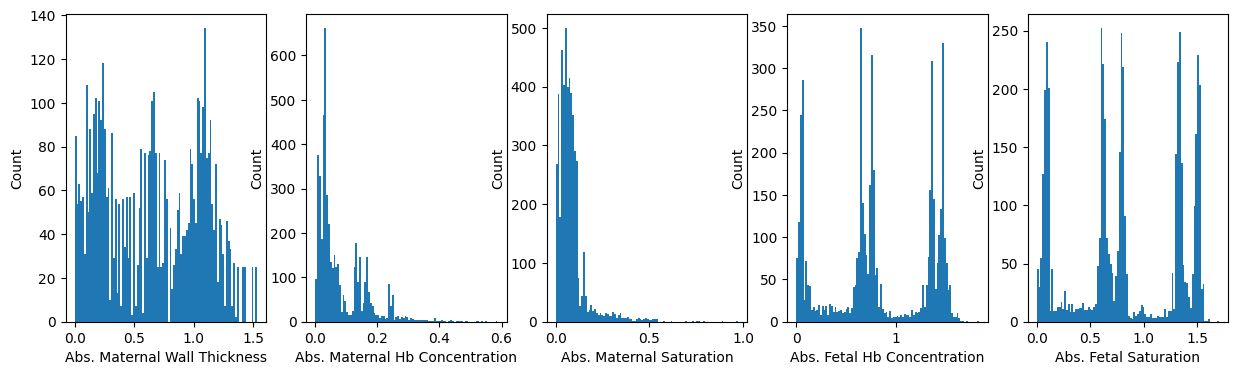

In [25]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = trainer.model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data)
    absolute_error = np.abs(y_data - predictions)
    # error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
    error_df = pd.DataFrame({y_columns[i]: absolute_error[:, i] for i in range(len(y_columns))})
fig, axes = plt.subplots(1, 5, squeeze=True, figsize=(15, 4))
for i in range(len(error_df.columns)):
    error_column = error_df.columns[i]
    ax = axes.flatten()[i]
    plt.sca(ax)
    error_df[error_column].plot.hist(bins=100)
    plt.xlabel(f'Abs. {error_column}')
    plt.ylabel('Count')
# plt.xlabel("Abs. Error")
plt.show()

In [27]:
error_df.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation
0,0.500610,0.407325,0.151838,1.251813,1.331326
1,0.462726,0.272686,0.036896,0.946873,1.001020
2,0.422244,0.156341,0.102973,0.529485,0.795923
3,0.412484,0.074992,0.262711,0.211937,0.474786
4,0.469389,0.040831,0.442408,0.213927,0.210864


In [26]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]  # Worst Results
# worst_errors = error_df['Absolute Error'].argsort()[:VIEW_TOP_N]  # Best Results
combined_table = data.join(error_df)
with pd.option_context("display.max_rows", None):
    display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

KeyError: 'Absolute Error'

In [ ]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

In [ ]:
# Model Info
torchinfo.summary(trainer.model)

In [ ]:
error_df.columns

In [ ]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [ ]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')